# GPU vs CPU Throughput Test Result Plots

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from azure.storage.blob import BlockBlobService
import pandas as pd

## Download data from blob storage¶ 

In [2]:
ACCOUNT_NAME = 'gputestingresults'
ACCOUNT_KEY = '8blS4Dga9zf50uzYWuDPmSxz9JAX0iryZkzxAy9PqSS5jD4+YPnmmqdylJBADwPb1RADChik+esJI380cN34Qw=='

In [3]:
blob_service = BlockBlobService(account_name=ACCOUNT_NAME, account_key=ACCOUNT_KEY)

In [4]:
containers = blob_service.list_containers()
blob_list = []
container_list = []
for c in containers:
    container_list.append(c.name)
    for b in blob_service.list_blobs(c.name):
#         print(b.name)
        blob_list.append(b.name)
container_list

['rawresultseastus', 'rawresultseurope', 'results']

In [5]:
CONTAINER_NAME = container_list[2]

In [6]:
xlsx_list = [b for b in blob_list if '.xlsx' in b and 'EastUS' in b]

In [7]:
df_RPS_50 = pd.DataFrame(columns = ['Model', 'Framework', 'Cluster', 'RPS'])
for XLS_FILE in xlsx_list:
#     print(XLS_FILE)
    DESTINATION_FILE = XLS_FILE.replace('GPUTesting/','')
    DESTINATION_FILE = DESTINATION_FILE.replace('EastUS_Client/','')
    DESTINATION_FILE = DESTINATION_FILE.replace('/','_')
    DESTINATION_FILE = os.path.join(os.getcwd(),DESTINATION_FILE)
    blob_service.get_blob_to_path(container_name=CONTAINER_NAME, blob_name=XLS_FILE, file_path=DESTINATION_FILE)
    df = pd.read_excel(io=DESTINATION_FILE, sheet_name='Client')
    df = df[['ThreadCount', 'AITime', 'RPS']]
    row = [DESTINATION_FILE.split('/')[3].split('_')[0], DESTINATION_FILE.split('/')[3].split('_')[2],DESTINATION_FILE.split('/')[3].split('_')[-3], float(df[df['ThreadCount']==50]['RPS'])]
    df_RPS_50.loc[len(df_RPS_50)] = row
    
#     print(DESTINATION_FILE)
#     print(df)
# df_RPS_50

In [8]:
df_RPS_50.replace('35Pod','5CPU', inplace=True )
df_RPS_50.replace('MobileNet','MobileNetV2', inplace=True )

In [9]:
df_RPS_50["Model"] = df_RPS_50["Model"].astype(pd.api.types.CategoricalDtype(categories=["NasNetLarge", "Resnet152", "NasNetMobile", "Resnet50", "MobileNetV2"]))

In [10]:
df_RPS_50

,Model,Framework,Cluster,RPS
0,MobileNetV2,Keras,1GPU,55.122564
1,MobileNetV2,Keras,2GPU,103.926475
2,MobileNetV2,Keras,3GPU,141.808522
3,MobileNetV2,Keras,5CPU,26.903556
4,MobileNetV2,TF,1GPU,57.126202
5,MobileNetV2,TF,2GPU,87.522886
6,MobileNetV2,TF,3GPU,116.936442
7,MobileNetV2,TF,5CPU,14.536675
8,NasNetLarge,Keras,5CPU,2.196386
9,NasNetLarge,Keras,1GPU,7.035507


In [11]:
df_RPS_50_pivot = pd.pivot_table(df_RPS_50, values='RPS', index=['Model', 'Framework'], columns=['Cluster'])

In [12]:
df_RPS_50_pivot

Cluster                      1GPU        2GPU        3GPU       5CPU
Model        Framework                                              
NasNetLarge  Keras       7.035507   13.816073   13.816073   2.196386
             TF         12.049442   21.804046   30.041518   4.014084
Resnet152    Keras      13.855050   26.467655   32.887834   5.199140
             TF         18.489864   35.703668   48.897105   6.680283
NasNetMobile Keras      24.122499   41.556104   50.420629   1.887626
             TF         39.291007   73.918280   87.554202  21.066518
Resnet50     Keras      31.834873   54.944249   76.459956  12.716302
             TF         43.162852   87.276227  109.304595  16.432399
MobileNetV2  Keras      55.122564  103.926475  141.808522  26.903556
             TF         57.126202   87.522886  116.936442  14.536675

In [14]:
df_RPS_50_pivot = df_RPS_50_pivot[['5CPU','1GPU','2GPU','3GPU']]

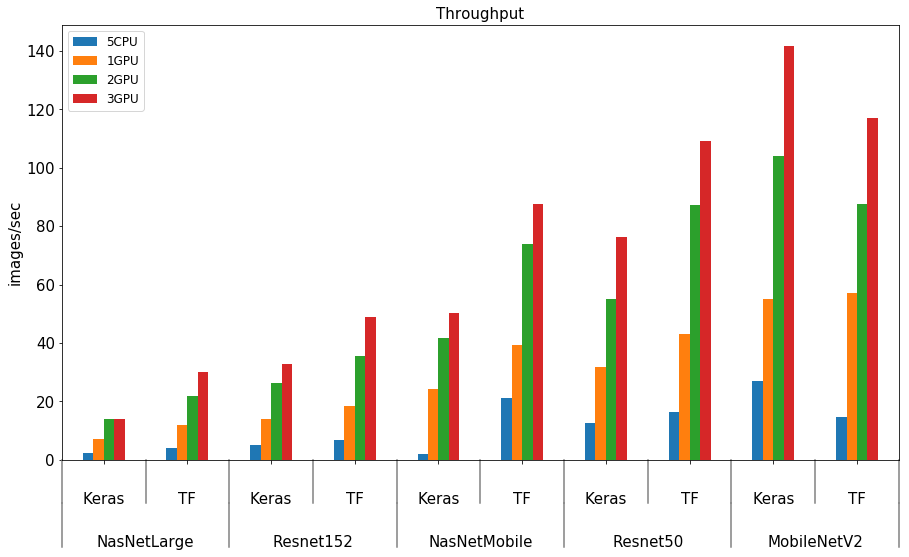

In [15]:
# referance: https://stackoverflow.com/questions/22780563/group-labels-in-matplotlib-barchart-using-pandas-multiindex

from itertools import groupby
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes, fontsize=15)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

# fig, ax = plt.subplots(figsize=(20, 10))
ax = df_RPS_50_pivot.plot(kind='bar',stacked=False, fontsize=15, figsize=(15,8))
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_title('Throughput', fontsize=15)
ax.set_ylabel('images/sec', fontsize=15)
ax.legend(loc='upper left',fontsize=12)
label_group_bar_table(ax, df_RPS_50_pivot)

In [17]:
df_RPS_50_pivot_GPU = df_RPS_50_pivot.drop(columns=['5CPU'])
df_RPS_50_pivot_GPU

Cluster                      1GPU        2GPU        3GPU
Model        Framework                                   
NasNetLarge  Keras       7.035507   13.816073   13.816073
             TF         12.049442   21.804046   30.041518
Resnet152    Keras      13.855050   26.467655   32.887834
             TF         18.489864   35.703668   48.897105
NasNetMobile Keras      24.122499   41.556104   50.420629
             TF         39.291007   73.918280   87.554202
Resnet50     Keras      31.834873   54.944249   76.459956
             TF         43.162852   87.276227  109.304595
MobileNetV2  Keras      55.122564  103.926475  141.808522
             TF         57.126202   87.522886  116.936442

In [18]:
df_RPS_50_pivot_GPU.transpose()

Model     NasNetLarge             Resnet152            NasNetMobile  \
Framework       Keras         TF      Keras         TF        Keras   
Cluster                                                               
1GPU         7.035507  12.049442  13.855050  18.489864    24.122499   
2GPU        13.816073  21.804046  26.467655  35.703668    41.556104   
3GPU        13.816073  30.041518  32.887834  48.897105    50.420629   

Model                  Resnet50             MobileNetV2              
Framework         TF      Keras          TF       Keras          TF  
Cluster                                                              
1GPU       39.291007  31.834873   43.162852   55.122564   57.126202  
2GPU       73.918280  54.944249   87.276227  103.926475   87.522886  
3GPU       87.554202  76.459956  109.304595  141.808522  116.936442

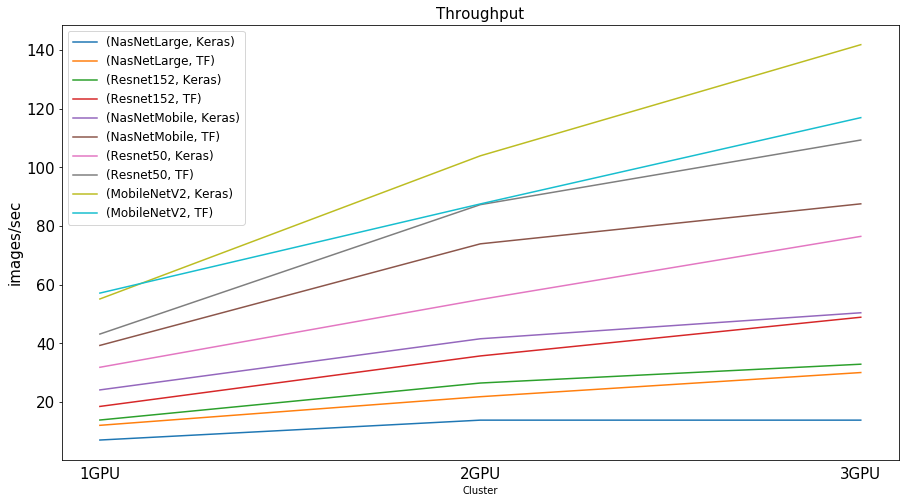

In [19]:
ax = df_RPS_50_pivot_GPU.transpose().plot(kind='line',fontsize=15, figsize=(15,8))
ax.set_xticklabels(['', '1GPU', '', '', '', '2GPU','','','', '3GPU'], fontsize=15)
ax.xaxis.set_ticks_position('none') 
# ax.set_xlabel('')
ax.set_title('Throughput', fontsize=15)
ax.set_ylabel('images/sec', fontsize=15)
ax.legend(title="", fontsize=12)

In [22]:
import numpy as np
np.asarray(df_RPS_50_pivot['5CPU'])

array([ 2.19638572,  4.01408433,  5.19914026,  6.68028349,  1.8876265 ,
       21.06651778, 12.7163024 , 16.43239878, 26.90355621, 14.53667499])

In [31]:
x = df_RPS_50_pivot['1GPU']  / np.asarray(df_RPS_50_pivot['5CPU']) * 100
x

Model         Framework
NasNetLarge   Keras         320.322033
              TF            300.179092
Resnet152     Keras         266.487319
              TF            276.782631
NasNetMobile  Keras        1277.927553
              TF            186.509261
Resnet50      Keras         250.346933
              TF            262.669210
MobileNetV2   Keras         204.889508
              TF            392.979842
Name: 1GPU, dtype: float64

In [32]:
x.mean()

373.9093382233219

In [27]:
x = df_RPS_50_pivot['3GPU'] / np.asarray(df_RPS_50_pivot['5CPU']) * 100
x

Model         Framework
NasNetLarge   Keras         629.036723
              TF            748.402756
Resnet152     Keras         632.562927
              TF            731.961530
NasNetMobile  Keras        2671.112606
              TF            415.608325
Resnet50      Keras         601.275069
              TF            665.177353
MobileNetV2   Keras         527.099542
              TF            804.423582
Name: 3GPU, dtype: float64

In [30]:
x.mean()

842.6660412882533